In [ ]:
# Downloading the style image (Monet painting) and a content image (DSLR image)

!wget https://i.etsystatic.com/5307484/r/il/163bc3/2964002069/il_570xN.2964002069_qzhb.jpg -O style_image.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Colosseo_2020.jpg/1200px-Colosseo_2020.jpg -O content_image.jpg

--2023-11-27 17:36:56--  https://i.etsystatic.com/5307484/r/il/163bc3/2964002069/il_570xN.2964002069_qzhb.jpg
Resolving i.etsystatic.com (i.etsystatic.com)... 23.14.90.107, 23.14.90.112
Connecting to i.etsystatic.com (i.etsystatic.com)|23.14.90.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169414 (165K) [image/jpeg]
Saving to: ‘style_image.jpg’

style_image.jpg     100%[===================>] 165.44K  --.-KB/s    in 0.03s   

2023-11-27 17:36:56 (6.42 MB/s) - ‘style_image.jpg’ saved [169414/169414]

--2023-11-27 17:36:56--  https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Colosseo_2020.jpg/1200px-Colosseo_2020.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 293216 (286K) [image/jpeg]
Saving to: ‘content_image.jpg’

content_image.jpg   100%[============

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# VGG19 pretrained model
vgg = models.vgg19(pretrained=True).features

# Freezing all VGG parameters
for param in vgg.parameters():
    param.requires_grad_(False)


def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')

    # Large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # Discard the alpha channel (if any) and add a batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

# Load content and style images (replace with your own images)
content = load_image("content_image.jpg").to(device)
style = load_image("style_image.jpg", shape=content.shape[-2:]).to(device)

In [ ]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
import copy
from tqdm import tqdm

vgg.to(device)

def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

# Content and style features
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Gram matrices for each layer
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

# Style and content weights (can be adjusted)
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.3,
                 'conv5_1': 0.2}

content_weight = 1
style_weight = 1e6

optimizer = optim.Adam([target], lr=0.01)
epochs = 2000

progress_bar = tqdm(range(epochs), desc='Training')
losses = []


for epoch in progress_bar:  # You can adjust the number of iterations

    target_features = get_features(target, vgg)

    # Content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Style loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)


    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    losses.append(total_loss.item())

    if (epoch + 1) % 2 == 0 or epoch == 0:
        progress_bar.set_postfix({'loss': total_loss.item()})


Training: 100%|██████████| 2000/2000 [00:51<00:00, 39.02it/s, loss=7.65e+5]


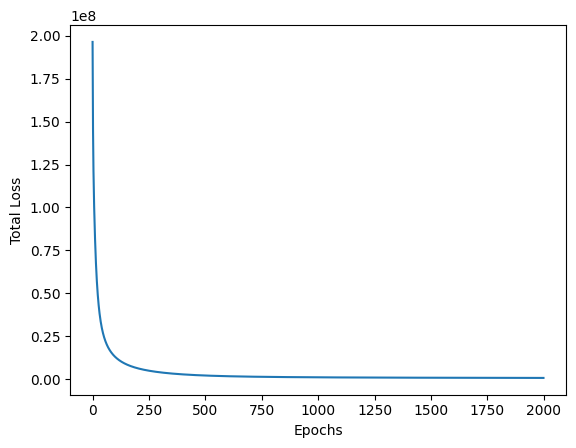

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.show()

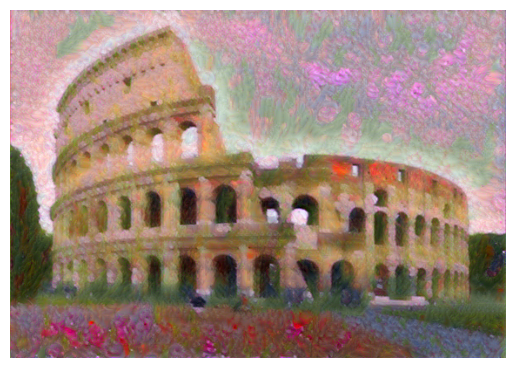

In [ ]:
from torchvision.utils import save_image


def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

# tensor to image
final_image = im_convert(target)
plt.imshow(final_image)
plt.axis('off')
plt.show()

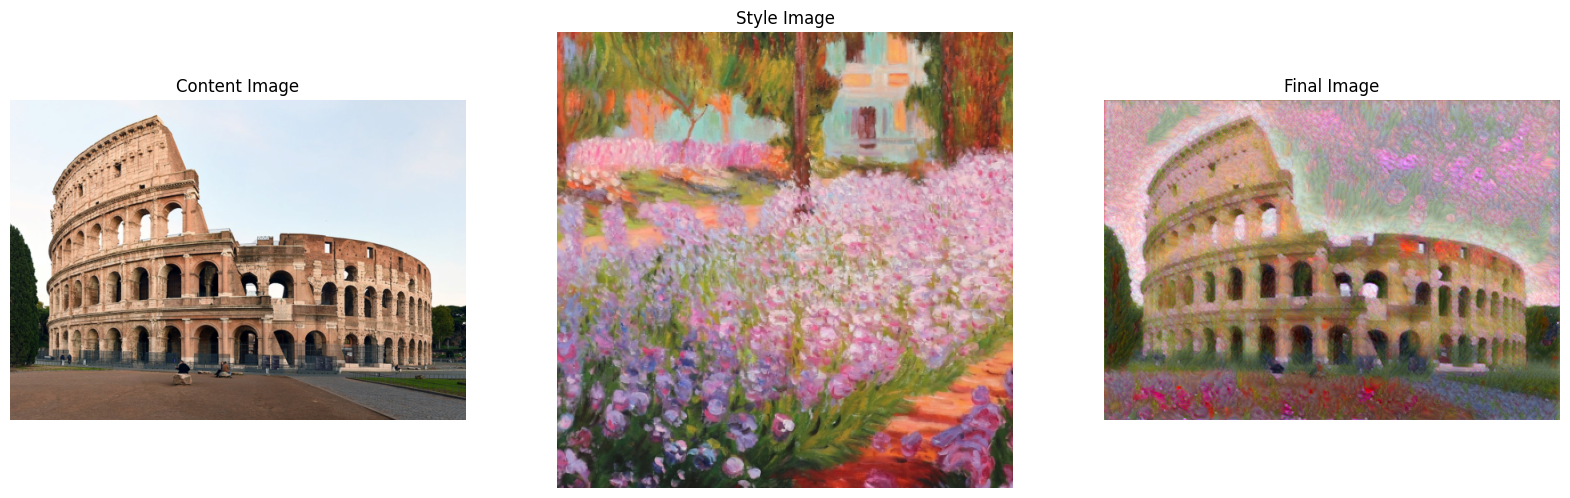

In [ ]:
content_image = im_convert(content)
style_image = im_convert(style)
final_image = im_convert(target)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

# Content image
ax1.imshow(content_image)
ax1.set_title('Content Image')
ax1.axis('off')

# Style image
ax2.imshow(style_image)
ax2.set_title('Style Image')
ax2.axis('off')

# Final image
ax3.imshow(final_image)
ax3.set_title('Final Image')
ax3.axis('off')

plt.show()

LIMITATION:
1. The model is blind on the context aspect. It only sees the style aspect.
2. If the input data is bigger then it takes more time to run the model.To tackle this problem we have resized the image as 400x400 pixel so the desired resolution is lost.

POTENTIAL:
1. To introduce context we can use another model.
2. postprocessing will improve resolution , sharpness and other required features.